In [67]:
!git clone https://github.com/fzamberlan/erowid.git >/dev/null 2>&1
!unrar x -Y "/content/erowid/Experiences.part01.rar" "/content/" >/dev/null 2>&1

In [68]:
!wget https://raw.githubusercontent.com/fzamberlan/scrapdrugs/refs/heads/master/Auxiliar/words_to_remove_slang.txt >/dev/null 2>&1
!wget https://raw.githubusercontent.com/fzamberlan/scrapdrugs/refs/heads/master/Auxiliar/borrar_palabras_2.txt >/dev/null 2>&1
!wget https://raw.githubusercontent.com/fzamberlan/scrapdrugs/refs/heads/master/Auxiliar/new_stopwords.txt >/dev/null 2>&1
!wget https://raw.githubusercontent.com/fzamberlan/scrapdrugs/refs/heads/master/Auxiliar/words_to_remove.txt >/dev/null 2>&1

In [69]:
import numpy as np
np.random.seed(24)


In [70]:

import json
import pandas as pd
import os

# Create an empty list to store the extracted data
data = []

# Loop through each JSON file in the directory
for filename in os.listdir('/content/Experiences'):
  if filename.endswith('.json'):
    filepath = os.path.join('/content/Experiences', filename)
    try:
      with open(filepath, 'r') as f:
        json_data = json.load(f)
        # Extract drug and text, handle potential key errors
        drug = json_data.get('drug', '')
        text = json_data.get('text', '')
        text = ''.join(text)
        text.replace("End Body",'')
        data.append({'drug': drug, 'text': text})
    except json.JSONDecodeError:
      print(f"Skipping invalid JSON file: {filename}")
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Create the pandas DataFrame
df = pd.DataFrame(data)
df.head()

Skipping invalid JSON file: 93869.json
Skipping invalid JSON file: 116305.json
Skipping invalid JSON file: 116262.json
Skipping invalid JSON file: 92422.json
Skipping invalid JSON file: 56028.json
Skipping invalid JSON file: 24001.json
Skipping invalid JSON file: 72544.json
Skipping invalid JSON file: 4918.json
Skipping invalid JSON file: 115378.json
Skipping invalid JSON file: 15608.json
Skipping invalid JSON file: 76840.json
Skipping invalid JSON file: 113126.json


,drug,text
0,Hydergine,After losing 60% of my liver function from mac...
1,Mushrooms &amp; LSD,While this was not technically my first acid t...
2,Methamphetamine,The first time that I tried meth was this past...
3,Ayahuasca,This is the first night experience over a week...
4,Alprazolam (Xanax),My Very First TimeWell I have been smoking wee...


In [71]:
def convert_txt_to_list(filepath):
  try:
    with open(filepath, 'r') as f:
      word_list = [line.strip() for line in f]
    return word_list
  except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
    return []

# Convert txt files to lists
list1 = convert_txt_to_list("/content/borrar_palabras_2.txt")
list2 = convert_txt_to_list("/content/words_to_remove_slang.txt")
list3 = convert_txt_to_list("/content/new_stopwords.txt")
list4 = convert_txt_to_list("/content/words_to_remove.txt")

# Concatenate the lists
borrar_palabras_list = list1 + list2 + list3 + list4

In [72]:

# Initialize an empty DataFrame to store the sampled data
df_sampled = pd.DataFrame()

# Group the DataFrame by the 'drug' column and sample 130 reports from each group
for drug_name, group_df in df.groupby('drug'):
    if len(group_df) > 130:
        df_sampled = pd.concat([df_sampled, group_df.sample(130, random_state=42)]) # Using random_state for reproducibility
    else:
        df_sampled = pd.concat([df_sampled, group_df])

# Overwrite the original DataFrame with the sampled DataFrame
df = df_sampled

# Display the first few rows of the new DataFrame
df.head()

# Verify the number of reports per drug (optional)
print("\nNumber of reports per drug after sampling:")
print(df['drug'].value_counts())

df.head()


Number of reports per drug after sampling:
drug
2C-I                                      130
2C-E                                      130
Mushrooms - P. cubensis                   130
Diphenhydramine                           130
4-AcO-DMT                                 130
                                         ... 
DXM (with CPM) &amp; Sertraline             1
DXM (with CPM), Cannabis &amp; Tobacco      1
DXM (with Chlorpheniramine)                 1
DXM (wtih CPM)                              1
DXM (Robitussin Max Strength)               1
Name: count, Length: 10528, dtype: int64


,drug,text
34206,\t 25I-NBOMe,"Background Information:First and foremost, I w..."
15450,\t 2C-E,I had fooled around with this research chemica...
18404,\t Products - Spice and Synthetic Cannabinoids,Never again. It’s been less than 12 hours sinc...
21703,"(Datura, Coleus, Aloe) Ointment &amp; LSD",It is now 11:35 P.M. as I sit here writing the...
39320,25B-NBOMe,Background: I’ve had many experiences with the...


In [73]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from nltk import pos_tag
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

class LemmaTokenizerPOS:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        words = word_tokenize(doc)
        tagged_words = pos_tag(words)
        result = []
        for word, tag in tagged_words:
            clean = ''.join(filter(str.isalnum, word)).lower()
            if clean and len(clean) > 2 and not any(char.isdigit() for char in clean):
                pos = get_wordnet_pos(tag)
                result.append(self.wnl.lemmatize(clean, pos=pos))
        return result

tokenizer = LemmaTokenizerPOS()

In [74]:
def clean_text(text):
    tokens = tokenizer(text)
    return " ".join([t for t in tokens if t not in stop_words])


In [75]:
import nltk

from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

cancelled_words = ['get', 'would', 'back', 'sometimes',"stoned", "hallucination",
                   "month", "year", "try", "summer", "experiment", "winter", 'hallucinate'
                   "report", "february", "trippy", "khole",
                   "depression", "cure", "apartment", "information", "day", "period", "introduction", "wlp",
                   "therapy", "march", "effect", "account", "like", 'look', 'think', 'body', 'come', 'feel', 'see', 'felt', 'know',]

stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(borrar_palabras_list)
stop_words.extend(cancelled_words)#############################################
stop_words.sort()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [76]:
import pandas as pd
import numpy as np # Import numpy for flattening

df_schizophrenia_raw = pd.read_csv("/content/Schizophrenia Reports - Sheet.csv")
# Apply clean_text to the 'REPORT' column directly
schiz_reports = [clean_text(r) for r in df_schizophrenia_raw["REPORT"]]

num = 100
random_seed=42

concat = [] # This will store one concatenated string per drug category
concat_individual = [] # This will store ALL individual report strings
labels = [] # This will store the drug label for EACH individual report

for drug in ["LSD", "DMT", "Mushrooms", "Cannabis", "Ketamine"]:
  if drug != "Mushrooms":
    reports = df[df["drug"]==drug]["text"].sample(n=num, random_state=random_seed)
  else:
    # Ensure you handle the potential that "Mushrooms" might not exactly match "Mushroom"
    # if the string contains other words like "Psilocybin Mushrooms".
    # The current regex '.str.contains("Mushroom")' is a good approach for this.
    reports = df[df["drug"].str.contains("Mushroom", na=False)]["text"].sample(n=num, random_state=random_seed) # Added na=False to handle potential NaN values in drug column if any exist

  reports_list = reports.tolist() # This should be a list of strings (individual reports)

  # Flatten the list of lists into a list of strings
  # This is necessary because reports_list appears to be a list of lists based on the traceback
  # NOTE: This flattening step might be unnecessary if reports.tolist() already returns a list of strings.
  # If reports.tolist() already returns a list of strings, the following line can be simplified to:
  # flattened_reports_list = reports_list
  # However, the original error did not stem from this section, so we will keep the original logic here.
  flattened_reports_list = [item for sublist in reports_list for item in (sublist if isinstance(sublist, list) else [sublist])]


  # Add the single concatenated string for this drug category to 'concat'
  # Use the flattened list for joining
  concat.append("".join(flattened_reports_list))

  # Add the individual report strings to 'concat_individual'
  # Use the flattened list
  concat_individual.extend(flattened_reports_list)

  # Add the drug label for each individual report
  labels.extend([drug] * len(flattened_reports_list)) # Add label for each sampled report


# Process Schizophrenia reports
# schiz_reports is now correctly a list of cleaned strings
# schiz_reports = list(df_schizophrenia["REPORT"]) # This line caused the error

# Add the single concatenated string for Schizophrenia to 'concat'
concat.append("".join(schiz_reports))

# Add the individual Schizophrenia reports to 'concat_individual'
concat_individual.extend(schiz_reports)

# Add the label for each Schizophrenia report
labels.extend(["Schizophrenia"] * len(schiz_reports))

# Verification (Optional):
print(f"Length of concat (aggregated reports per drug): {len(concat)}")
print(f"Length of concat_individual (all individual reports): {len(concat_individual)}")
print(f"Length of labels (labels for individual reports): {len(labels)}")
# Check if lengths match (total number of individual reports)
assert len(concat_individual) == len(labels), "Mismatch in the number of individual reports and labels."

Length of concat (aggregated reports per drug): 6
Length of concat_individual (all individual reports): 630
Length of labels (labels for individual reports): 630


In [77]:
# Assuming schiz_reports is a list of strings where each string is a cleaned report.
# Flatten the list of lists of words into a single list of words
schiz_words = [word for report in schiz_reports for word in report.split()]

# Count the total number of words
num_words_schizophrenia = len(schiz_words)

print(f"Number of words in the Schizophrenia dataset: {num_words_schizophrenia}")


Number of words in the Schizophrenia dataset: 3847


In [78]:
# Create a dictionary to store word counts for each drug
word_counts_per_drug = {}

# Group the individual reports and labels by drug
drug_reports = {}
for i, label in enumerate(labels):
    if label not in drug_reports:
        drug_reports[label] = []
    drug_reports[label].append(concat_individual[i])

# Iterate through each drug and calculate the word count
for drug, reports in drug_reports.items():
    total_words = 0
    for report in reports:
        total_words += len(report.split())
    word_counts_per_drug[drug] = total_words

# Print the word counts for each drug
for drug, count in word_counts_per_drug.items():
    print(f"Number of words in 'concat_individual' for {drug}: {count}")


Number of words in 'concat_individual' for LSD: 135775
Number of words in 'concat_individual' for DMT: 106413
Number of words in 'concat_individual' for Mushrooms: 143018
Number of words in 'concat_individual' for Cannabis: 79486
Number of words in 'concat_individual' for Ketamine: 90567
Number of words in 'concat_individual' for Schizophrenia: 3847


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Ensure nltk downloads are complete before running this cell
# nltk.download('averaged_perceptron_tagger_eng') # Already in a previous cell

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer, lowercase=True, strip_accents='unicode', ngram_range=(1,1)) #min_df=0.05, max_df=0.95,
tfidf_array = tfidf_vectorizer.fit_transform(concat_individual)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Shape of TF-IDF array: {tfidf_array.shape}") # Added print to verify shape
print(f"Number of features: {len(feature_names)}")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abchminaca', 'abfubinaca', 'abpinaca', 'allad', 'ambil', 'aphp', 'apvp', 'aus', 'baked', 'baking', 'bcomplex', 'bkdmbdb', 'bkebdp', 'bkepdb', 'bkmbdb', 'bkmbdp', 'bkmddma', 'bkmdea', 'bkmdma', 'blossoming', 'brdfly', 'broken', 'cacti', 'captivate', 'cigarettes', 'cipu', 'cliche', 'clove', 'combined', 'crunched', 'crystallize', 'cv', 'damphetamine', 'dlalpha', 'dlalphamethyltrypamine', 'dy', 'eaten', 'ebomb', 'ecigarette', 'el', 'etait', 'explodes', 'extracted', 'fiancac', 'filtering', 'folding', 'fur', 'gefuhl', 'hr', 'huhu', 'iam', 'idoser', 'ihad', 'imbued', 'infected', 'injected', 'insufflated', 'ldopa'

Shape of TF-IDF array: (630, 18327)
Number of features: 18327


In [80]:
import pandas as pd

# Assuming 'tfidf_array', 'feature_names', and 'labels' are defined from the previous code

# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_array.toarray(), columns=feature_names)

# Add the labels back to the DataFrame
tfidf_df['label'] = labels

# Group by label and sum the TF-IDF values for each word
top_words_df = tfidf_df.groupby('label').sum()

# Display the top N words for each label
num_top_words = 10  # Change this to show more or fewer top words
for label in top_words_df.index:
    print(f"\nTop {num_top_words} words for {label}:")
    print(top_words_df.loc[label].sort_values(ascending=False).head(num_top_words))



Top 10 words for Cannabis:
really    3.936551
make      3.925368
say       3.710084
around    3.383028
thing     3.261848
tell      3.257788
hour      3.210885
never     3.062113
begin     3.051082
find      3.049139
Name: Cannabis, dtype: float64

Top 10 words for DMT:
begin         4.609779
say           3.910268
thing         3.744672
everything    3.614466
close         3.277088
seem          3.195721
minute        3.189251
make          3.184703
want          3.117527
much          3.082524
Name: DMT, dtype: float64

Top 10 words for Ketamine:
remember      4.055040
minute        3.877084
seem          3.736056
around        3.639693
really        3.611826
make          3.427738
mind          3.269925
much          3.263226
thing         3.254705
everything    3.144020
Name: Ketamine, dtype: float64

Top 10 words for LSD:
say       5.185877
around    5.104857
walk      4.432456
really    4.279898
hour      4.274158
mind      3.993113
decide    3.887577
make      3.833654
begin   

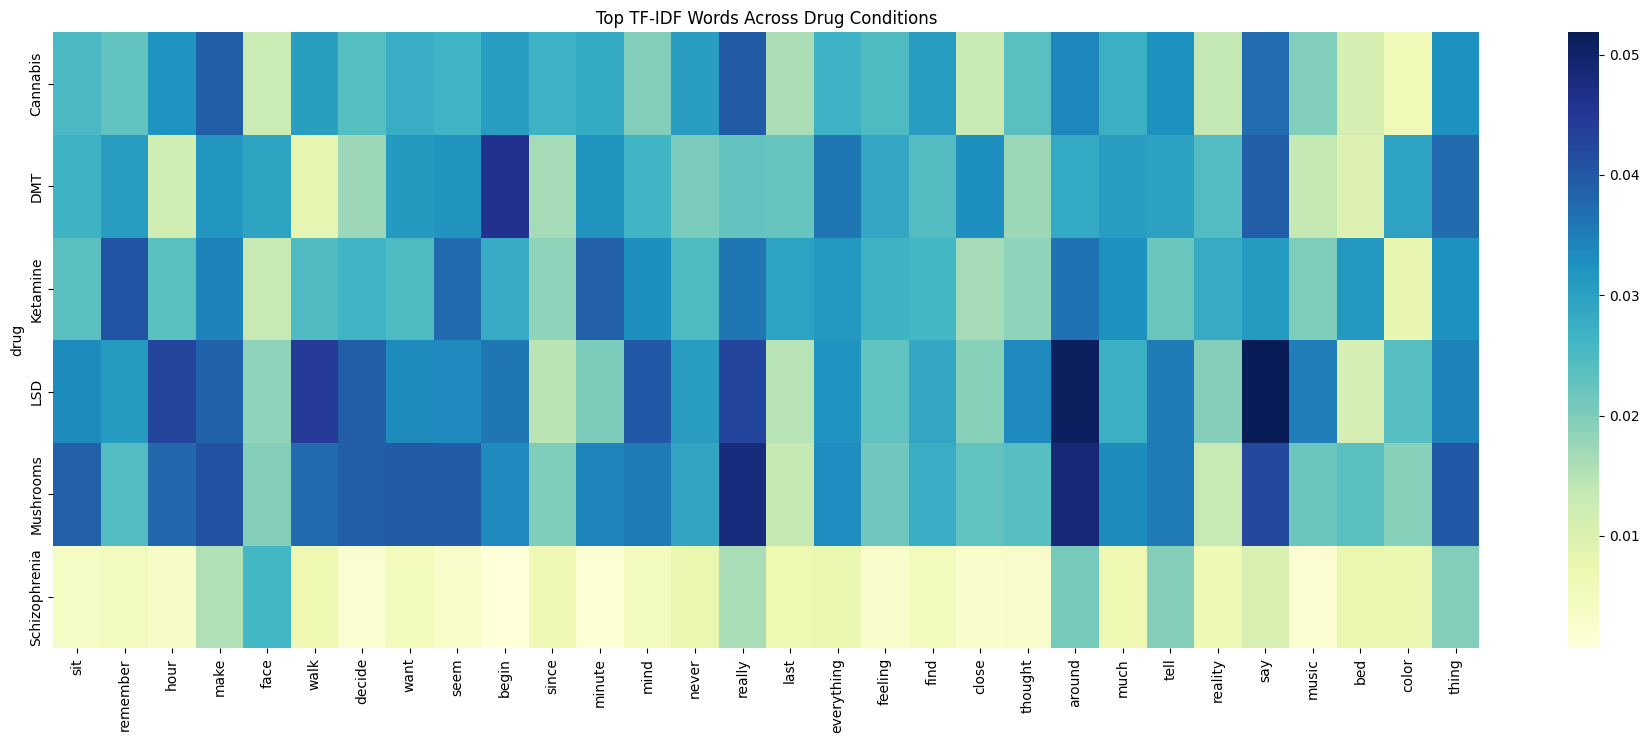

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_array.toarray(), columns=feature_names)
tfidf_df['drug'] = labels

# Select the top N TF-IDF words (adjust N as needed)
N = 15
top_words = []
for drug in ["LSD", "DMT", "Mushrooms", "Cannabis", "Ketamine"]:
    drug_df = tfidf_df[tfidf_df['drug'] == drug]
    top_words_drug = drug_df.drop(columns='drug').mean().nlargest(N).index.tolist()
    top_words.extend(top_words_drug)

top_words = list(set(top_words))  # Get unique top words

# Filter the DataFrame to include only the top words
tfidf_top_words = tfidf_df[top_words + ['drug']]

# Calculate the mean TF-IDF for each word and drug
heatmap_data = tfidf_top_words.groupby('drug').mean()

# Create the heatmap
plt.figure(figsize=(23, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", fmt=".2f")
plt.title(f"Top TF-IDF Words Across Drug Conditions")
plt.show()


In [82]:
# from sklearn.metrics import pairwise_distances
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.spatial.distance import cosine

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
lsa_model = TruncatedSVD(n_components=2)
lsa_comps = lsa_model.fit_transform(tfidf_array)
lsa_df = pd.DataFrame(lsa_comps, columns=["LSA Component 1", "LSA Component 2"])
lsa_df["drug"] = labels

In [83]:
lsa_df

,LSA Component 1,LSA Component 2,drug
0,0.164941,-0.047329,LSD
1,0.177585,-0.033559,LSD
2,0.214082,0.009024,LSD
3,0.250253,-0.065584,LSD
4,0.345491,-0.052968,LSD
...,...,...,...
625,0.096714,0.265156,Schizophrenia
626,0.066105,0.021090,Schizophrenia
627,0.068541,0.083771,Schizophrenia
628,0.164971,0.123785,Schizophrenia


<ipython-input-84-ebf31737e33e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(lsa_df, x='LSA Component 2', y='drug', inner='box', palette='Dark2')


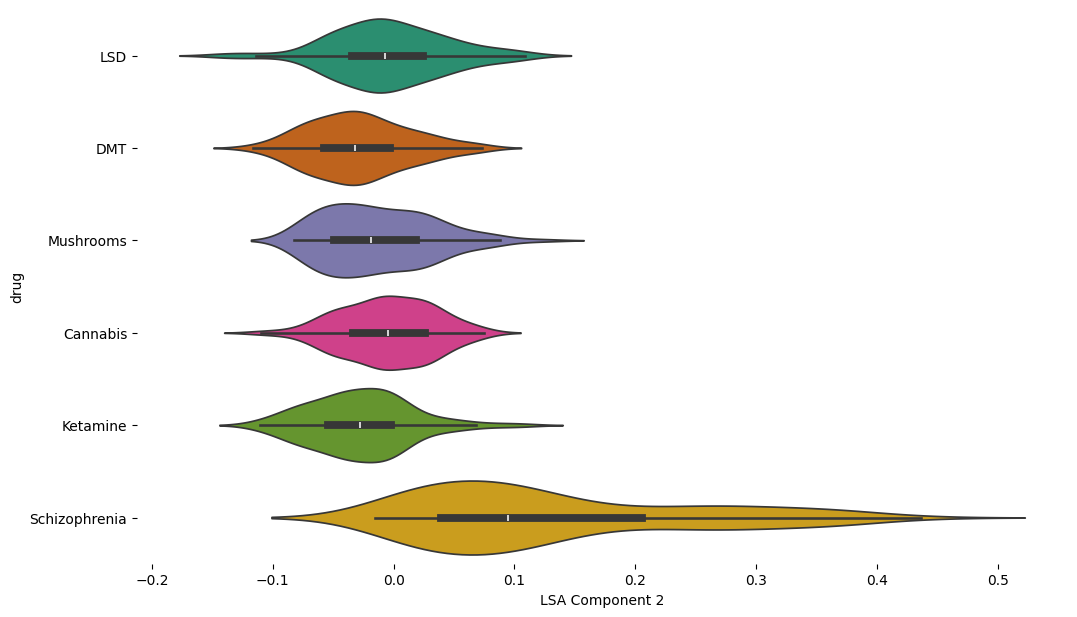

In [84]:
# @title drug vs LSA Component 2

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(lsa_df['drug'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(lsa_df, x='LSA Component 2', y='drug', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-85-067fa9cb8a2d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(lsa_df, x='LSA Component 1', y='drug', inner='box', palette='Dark2')


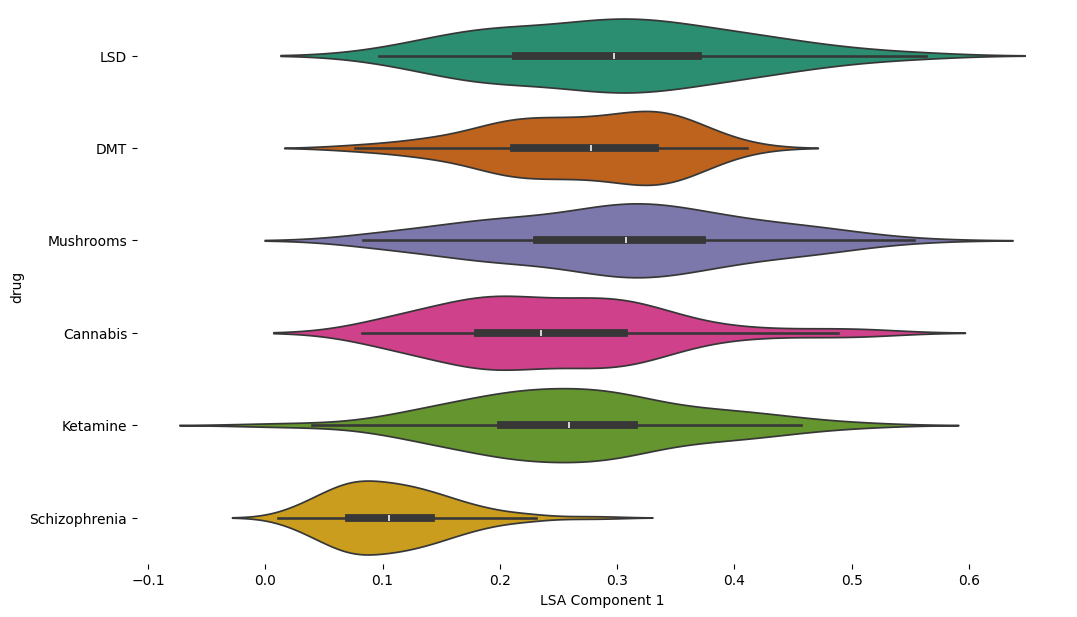

In [85]:
# @title drug vs LSA Component 1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(lsa_df['drug'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(lsa_df, x='LSA Component 1', y='drug', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

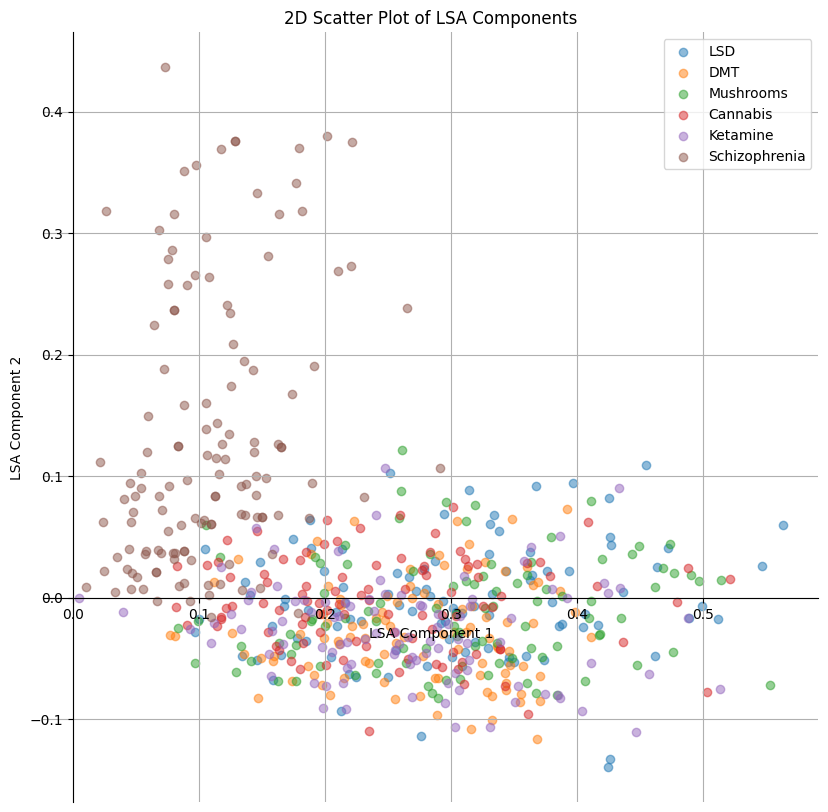

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

for drug in ["LSD", "DMT", "Mushrooms", "Cannabis", "Ketamine", "Schizophrenia"]:
    drug_df = lsa_df[lsa_df["drug"] == drug]
    ax.scatter(drug_df.iloc[:, 0], drug_df.iloc[:, 1], label=drug, alpha=0.5)

# for i, txt in enumerate(labels):
#     ax.annotate(txt, (lsa_comps[i, 0], lsa_comps[i, 1]), fontsize=12)
#     #plt.text(lsa_comps[i, 0] + 0.05, lsa_comps[i, 1] + 0.05, txt, fontsize=9) # Floating text
#     ax.scatter(lsa_comps[i, 0], lsa_comps[i, 1], label=txt)

ax.spines['top'].set_color('none') # Eliminate upper axes
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none') # Eliminate right axis
ax.spines['left'].set_position('zero') #('center')

ax.set_xlabel("LSA Component 1")
ax.set_ylabel("LSA Component 2")
ax.set_title("2D Scatter Plot of LSA Components")
ax.grid(True)
#plt.gca().set_aspect('equal')#, adjustable='box')
plt.legend(loc='upper right')
plt.show()

In [87]:

import numpy as np

# Get the loadings of the components
loadings = lsa_model.components_

# Create a DataFrame for PC1 and PC2 loadings
loading_matrix = pd.DataFrame(loadings.T, index=feature_names, columns=['LSA Component 1', 'LSA Component 2'])

# Function to display top words for a given component
def display_top_words(component, top_n=10):
    print(f"\nTop {top_n} words for {component}:")
    print(loading_matrix.sort_values(by=component, ascending=False).head(top_n))

# Show top words for PC1
display_top_words('LSA Component 1')

# Show top words for PC2
display_top_words('LSA Component 2')



Top 10 words for LSA Component 1:
        LSA Component 1  LSA Component 2
say            0.150823         0.038519
around         0.148302         0.061053
really         0.141170         0.028210
make           0.136040        -0.000104
thing          0.132061         0.053476
tell           0.121665         0.103492
begin          0.120271        -0.087139
seem           0.118481        -0.063784
want           0.117263        -0.008526
mind           0.113774        -0.078537

Top 10 words for LSA Component 2:
          LSA Component 1  LSA Component 2
people           0.105523         0.379450
shadow           0.024391         0.370064
voice            0.046835         0.241735
auditory         0.016013         0.237029
whisper          0.013009         0.166922
hear             0.071663         0.162018
corner           0.020331         0.155883
crawl            0.015565         0.132058
animal           0.014886         0.124141
scream           0.022069         0.120881


PCA

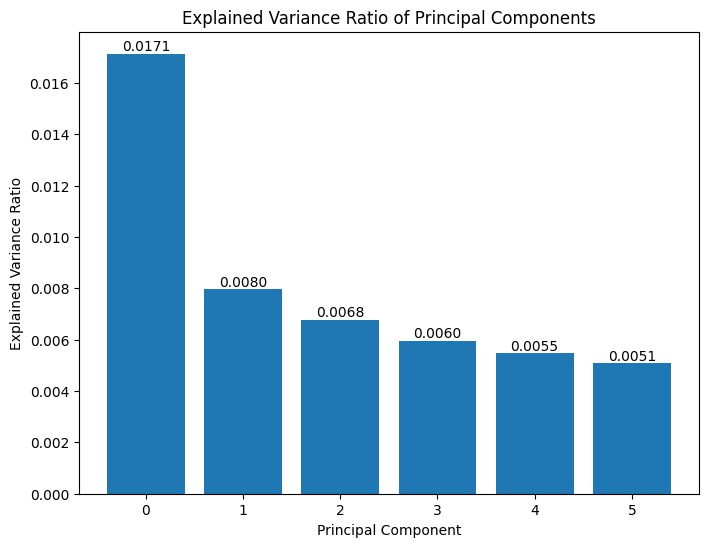

In [88]:
import matplotlib.pyplot as plt

# Assuming lsa_model is already defined from the previous code
pca = PCA(n_components=6)
pca.fit(tfidf_array)

explained_variance_ratio = pca.explained_variance_ratio_

# Create the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio of Principal Components")

# Add the exact value on top of each bar
for bar, value in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4f}", ha='center', va='bottom')

plt.show()


KDE


Peaks detected:
LSD: 1 peaks detected
DMT: 1 peaks detected
Mushrooms: 1 peaks detected
Cannabis: 1 peaks detected
Ketamine: 1 peaks detected
Schizophrenia: 2 peaks detected


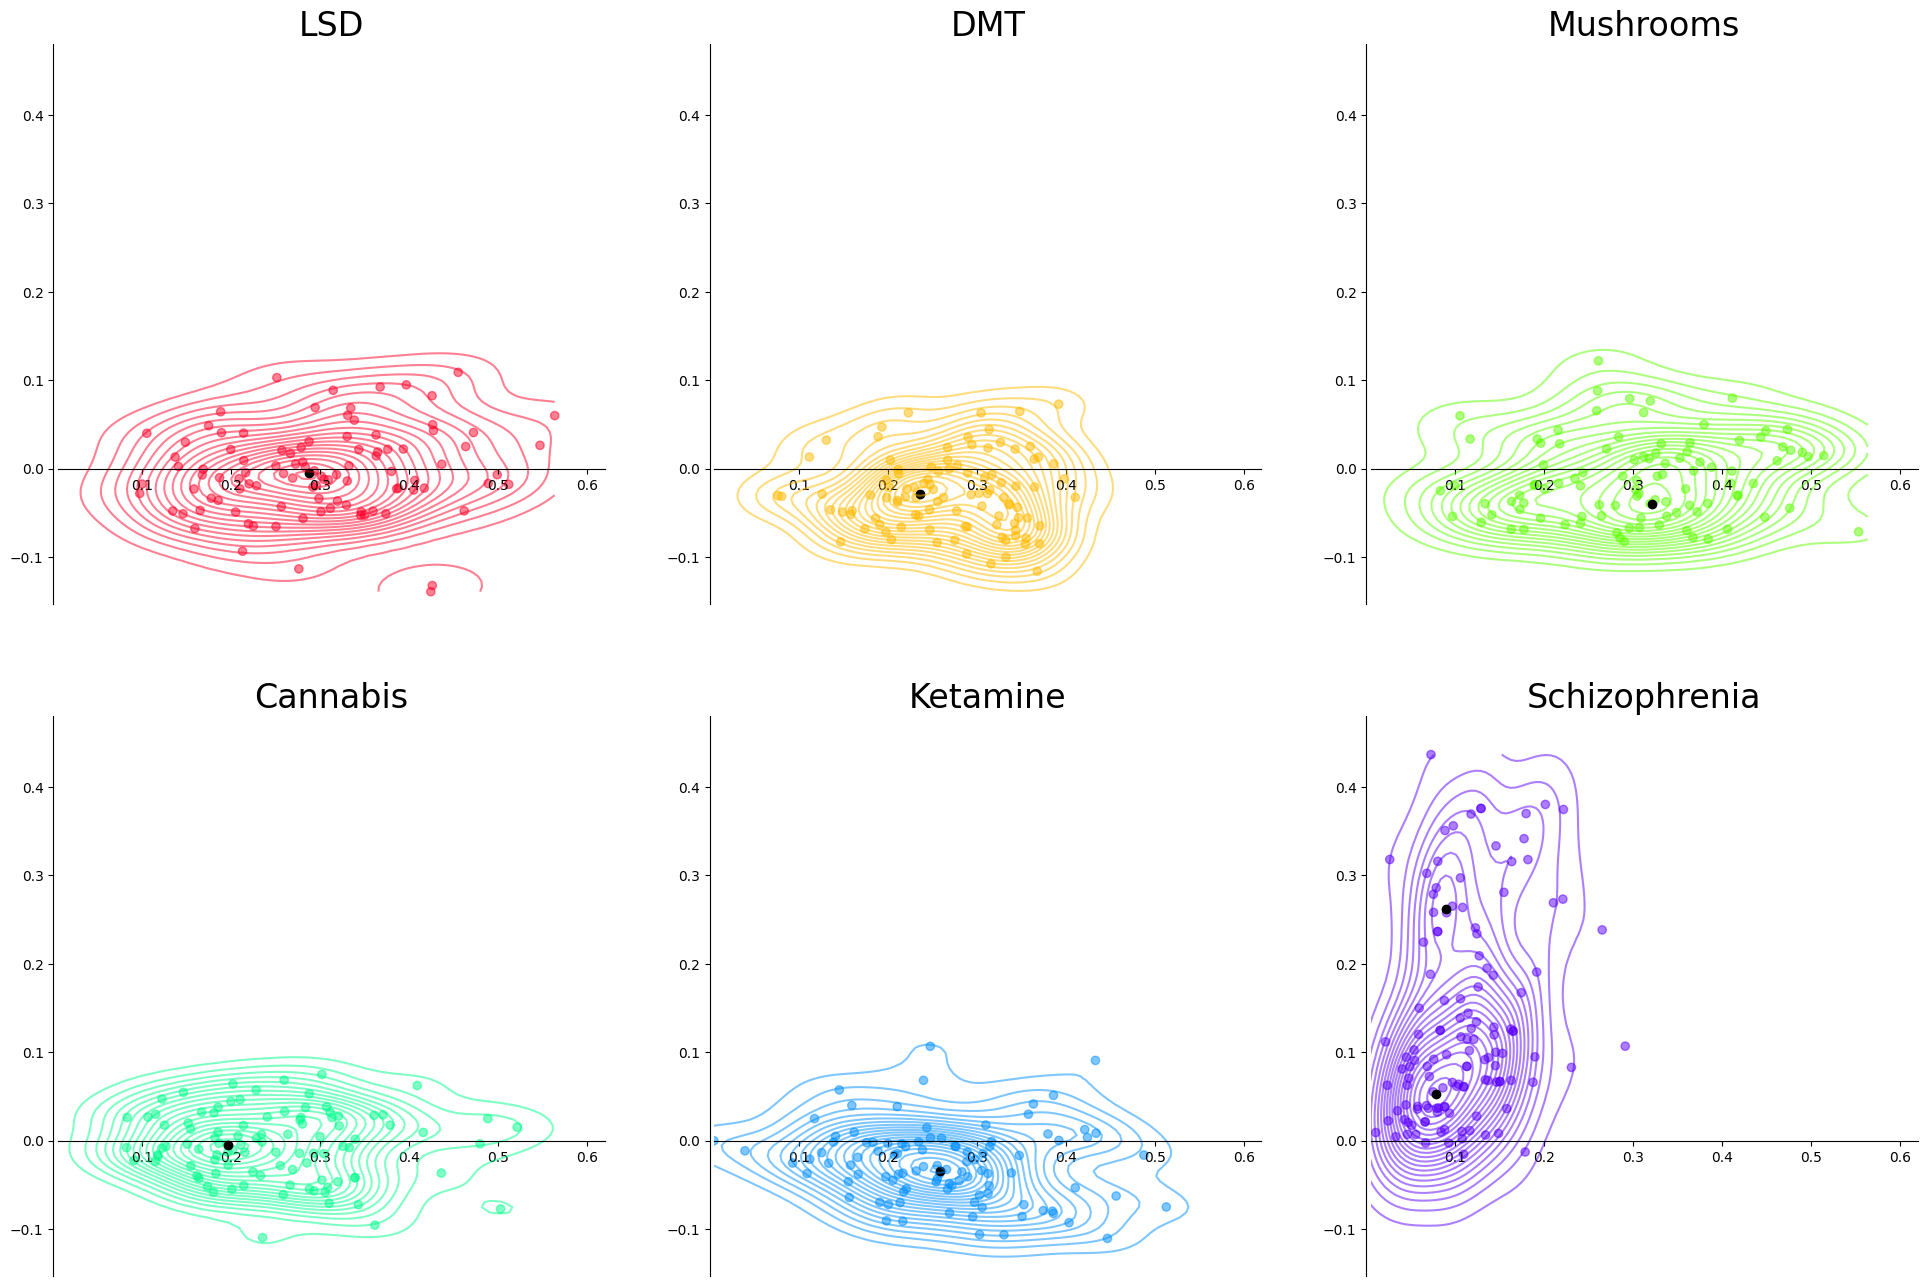

In [89]:
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.ndimage import maximum_filter #, label, find_objects
import numpy as np

import matplotlib.patches as mpatches
from matplotlib import colormaps

lig_list = ["LSD", "DMT", "Mushrooms", "Cannabis", "Ketamine", "Schizophrenia"]

cmap = colormaps["gist_rainbow"]
color_dict = {lig:cmap(i/6) for i,lig in enumerate(lig_list)}
lsa_df["color"] = lsa_df["drug"].map(color_dict)

n_cols = 3
n_rows = 2
fig, ax = plt.subplots(figsize=(8*n_cols,8*n_rows), ncols=n_cols, nrows=n_rows)
axs = ax.flatten()

x_min, x_max = lsa_df.iloc[:,0].min(), lsa_df.iloc[:,0].max()
y_min, y_max = lsa_df.iloc[:,1].min(), lsa_df.iloc[:,1].max()

peaks_dict = {}
for i, lig in enumerate(lig_list):
    axs[i].scatter(lsa_df[lsa_df["drug"]==lig].iloc[:,0],
                     lsa_df[lsa_df["drug"]==lig].iloc[:,1], alpha=0.5,
                     c=lsa_df[lsa_df["drug"]==lig].iloc[:,3])
    #legends = [mpatches.Patch(color=color_dict[lig], label=lig)]
    axs[i].spines['top'].set_color('none')
    axs[i].spines['bottom'].set_position('zero')
    axs[i].spines['right'].set_color('none')
    axs[i].spines['left'].set_position('zero')
    axs[i].set_xlim(x_min*1.1, x_max*1.1)
    axs[i].set_ylim(y_min*1.1, y_max*1.1)
    #axs[i].legend(handles=legends)
    axs[i].set_title(lig, fontsize=24)

    points_lig = lsa_df[lsa_df["drug"]==lig].iloc[:,:2].values

    x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([x.ravel(), y.ravel()])

    kde = gaussian_kde(points_lig.T)
    density = kde(positions).reshape(x.shape)

    axs[i].contour(x, y, density, levels=20, alpha=0.5, colors=color_dict[lig])

    neighborhood = maximum_filter(density, size=20)  # Adjust size for peak sensitivity
    peaks = (density == neighborhood) & (density > np.percentile(density, 90))  # Top X% density
    peak_indices = np.array(np.nonzero(peaks)).T
    peak_coords = np.column_stack([x[peak_indices[:, 0], peak_indices[:, 1]],
                                   y[peak_indices[:, 0], peak_indices[:, 1]]])

    peaks_dict[lig] = peak_coords
    axs[i].scatter(peak_coords[:, 0], peak_coords[:, 1], c='k')

# Add this to check the peaks
print("\nPeaks detected:")
for key, value in peaks_dict.items():
    print(f"{key}: {value.shape[0]} peaks detected")

plt.show()

In [90]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

schizophrenia_peaks = peaks_dict.get("Schizophrenia")
if schizophrenia_peaks is None or len(schizophrenia_peaks) == 0:
    print("No peaks found for Schizophrenia. Cannot calculate similarity.")
else:
    schizophrenia_peak_avg = np.mean(schizophrenia_peaks, axis=0).reshape(1, -1)

    print("\nCosine Similarity with Schizophrenia Peak:")
    for drug in ["LSD", "DMT", "Mushrooms", "Cannabis", "Ketamine"]:
        drug_peaks = peaks_dict.get(drug)

        if drug_peaks is None or len(drug_peaks) == 0:
            print(f"  {drug}: No peaks found. Cannot calculate similarity.")
            continue

        if len(drug_peaks) == 1:
            drug_peak_avg = drug_peaks[0].reshape(1, -1)
            similarity = cosine_similarity(schizophrenia_peak_avg, drug_peak_avg)[0][0]
            print(f"  {drug}: {similarity:.4f} (Single peak)")
        elif len(drug_peaks) > 1:
            # For multiple peaks, we can average the peaks or find the densest one.
            # Averaging is simpler and often sufficient.
            # Finding the densest would require re-calculating density around each peak.
            # Let's average for simplicity as per the request.
            drug_peak_avg = np.mean(drug_peaks, axis=0).reshape(1, -1)
            similarity = cosine_similarity(schizophrenia_peak_avg, drug_peak_avg)[0][0]
            print(f"  {drug}: {similarity:.4f} (Average of {len(drug_peaks)} peaks)")



Cosine Similarity with Schizophrenia Peak:
  LSD: 0.4519 (Single peak)
  DMT: 0.3586 (Single peak)
  Mushrooms: 0.3548 (Single peak)
  Cannabis: 0.4440 (Single peak)
  Ketamine: 0.3477 (Single peak)


In [91]:
from scipy.spatial.distance import pdist, squareform

sim_matrix = squareform(pdist(peak_coords, metric='cosine'))

In [92]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np # Import numpy to check array shape

# Assuming 'peaks_dict' is defined from the previous code

# Calculate cosine similarity between peak coordinates for each drug
similarity_results = {}
for drug1 in peaks_dict:
    for drug2 in peaks_dict:
        if drug1 != drug2:
            # Check if both arrays have at least one sample
            if peaks_dict[drug1].shape[0] > 0 and peaks_dict[drug2].shape[0] > 0:
                similarities = cosine_similarity(peaks_dict[drug1], peaks_dict[drug2])
                # Store the mean similarity for the pair
                similarity_results[(drug1, drug2)] = np.mean(similarities)
            else:
                # Handle cases where one or both drugs have no detected peaks
                # You might want to assign a default similarity (e.g., 0 or NaN)
                # or simply skip the comparison for this pair.
                # For this fix, we'll assign NaN to indicate no comparison was possible.
                similarity_results[(drug1, drug2)] = np.nan
                print(f"Skipping similarity calculation for {drug1} and {drug2} due to no detected peaks in one or both.")


# Print or process the results
for (drug1, drug2), similarity in similarity_results.items():
    # Print or process the results, handling potential NaN values
    if np.isnan(similarity):
         print(f"Cosine Similarity between {drug1} and {drug2}: Not calculated (no peaks)")
    else:
         print(f"Cosine Similarity between {drug1} and {drug2}: {similarity}")

Cosine Similarity between LSD and DMT: 0.9947855273107507
Cosine Similarity between LSD and Mushrooms: 0.9943700134410353
Cosine Similarity between LSD and Cannabis: 0.9999607508512945
Cosine Similarity between LSD and Ketamine: 0.9935297409466691
Cosine Similarity between LSD and Schizophrenia: 0.5607959809374192
Cosine Similarity between DMT and LSD: 0.9947855273107507
Cosine Similarity between DMT and Mushrooms: 0.9999920150758845
Cosine Similarity between DMT and Cannabis: 0.9956500889381307
Cosine Similarity between DMT and Ketamine: 0.9999321256845497
Cosine Similarity between DMT and Schizophrenia: 0.4799321023123987
Cosine Similarity between Mushrooms and LSD: 0.9943700134410353
Cosine Similarity between Mushrooms and DMT: 0.9999920150758845
Cosine Similarity between Mushrooms and Cannabis: 0.9952698054180734
Cosine Similarity between Mushrooms and Ketamine: 0.9999707009717156
Cosine Similarity between Mushrooms and Schizophrenia: 0.47666173261805367
Cosine Similarity between C

Cosine Similarity between Schizophrenia and Drugs (Based on LSA Peaks)

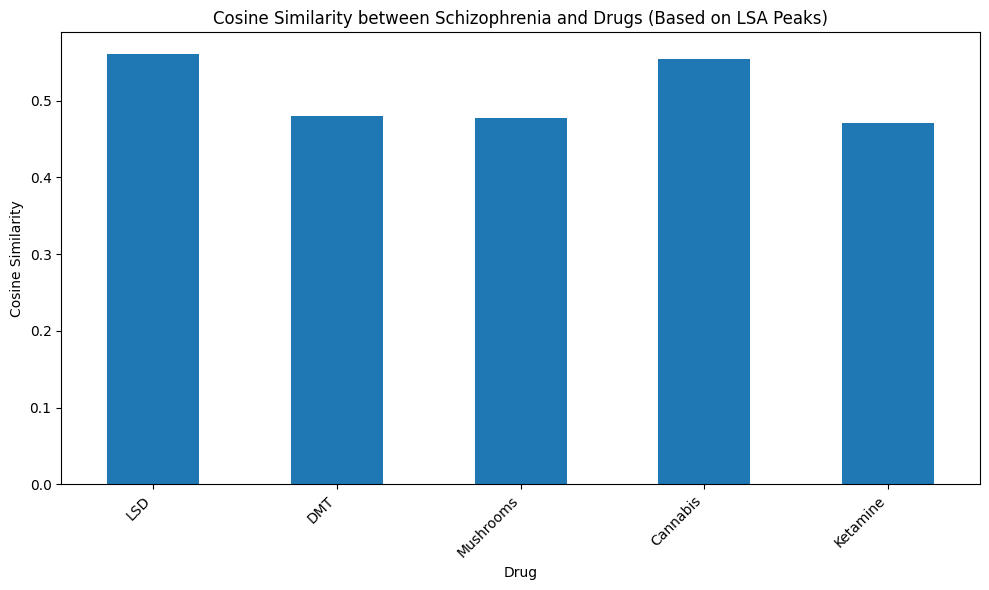

LSD          0.560796
DMT          0.479932
Mushrooms    0.476662
Cannabis     0.554003
Ketamine     0.470376
dtype: float64


In [93]:
schizophrenia_similarities = {
    drug: similarity for (drug1, drug), similarity in similarity_results.items()
    if drug1 == "Schizophrenia"
}

# Convert the dictionary to a pandas Series for easy plotting
schizophrenia_similarity_series = pd.Series(schizophrenia_similarities)

# Remove the comparison of Schizophrenia with itself (if present)
if "Schizophrenia" in schizophrenia_similarity_series.index:
    schizophrenia_similarity_series = schizophrenia_similarity_series.drop("Schizophrenia")

# Create the bar graph
plt.figure(figsize=(10, 6))
schizophrenia_similarity_series.plot(kind='bar')
plt.title('Cosine Similarity between Schizophrenia and Drugs (Based on LSA Peaks)')
plt.xlabel('Drug')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()
print(schizophrenia_similarity_series)

Highest and lowest words for LSA components

In [94]:
ranking = pd.DataFrame()
ranking["words"] = feature_names
lsa_model.fit(tfidf_array)
ranking["LSA Component 1"] = lsa_model.components_[0,:]
ranking["LSA Component 2"] = lsa_model.components_[1,:]

In [95]:
print(ranking.sort_values(by="LSA Component 1", ascending=False).head(10))
print()
print(ranking.sort_values(by="LSA Component 1", ascending=True).head(10))
print()
print()
print(ranking.sort_values(by="LSA Component 2", ascending=False).head(10))
print()
print(ranking.sort_values(by="LSA Component 2", ascending=True).head(10))

        words  LSA Component 1  LSA Component 2
13806     say         0.150823         0.042508
884    around         0.148302         0.063521
12907  really         0.141170         0.031590
9539     make         0.136040        -0.003839
16094   thing         0.132061         0.056287
15872    tell         0.121665         0.108735
1413    begin         0.120271        -0.086665
13982    seem         0.118481        -0.053112
17625    want         0.117263        -0.006698
10004    mind         0.113774        -0.072188

                   words  LSA Component 1  LSA Component 2
18310             ziehen         0.000004        -0.000003
18323  zuruckgebliebenen         0.000004        -0.000003
18320          zufrieden         0.000004        -0.000003
14786          sonderbar         0.000004        -0.000003
8708              kaufen         0.000004        -0.000003
8709                kaum         0.000004        -0.000003
8719              kehrte         0.000004        -0.000003

clustering algorithm - unused

In [96]:
from sklearn.cluster import KMeans

# Assuming 'tfidf_array' is your TF-IDF matrix and 'labels' are the corresponding drug labels
# from the previous code

# Apply KMeans clustering (you can adjust the number of clusters 'n_clusters')
kmeans = KMeans(n_clusters=6, random_state=0)  # Experiment with different values of n_clusters
kmeans.fit(tfidf_array)
cluster_labels = kmeans.labels_

# Create a DataFrame to store the results
cl_results_df = pd.DataFrame({'drug': labels, 'cluster': cluster_labels})

# Analyze the clusters to see if Schizophrenia and any drug reports fall in the same cluster
print(cl_results_df)

# Group data by cluster
clustered_data = cl_results_df.groupby('cluster')['drug'].apply(list).reset_index(name='drugs_in_cluster')

# Find clusters containing "Schizophrenia"
schizophrenia_clusters = clustered_data[clustered_data['drugs_in_cluster'].apply(lambda x: 'Schizophrenia' in x)]

# Print the drugs in clusters with "Schizophrenia"
for _, row in schizophrenia_clusters.iterrows():
  print(f"Cluster {row['cluster']} contains: {row['drugs_in_cluster']}")

# Further Analysis:
# You could inspect the drugs grouped in the same cluster as 'Schizophrenia' and see if those are indeed
# similar to reports of Schizophrenia based on your domain knowledge.

# Visualization:
# It is highly recommended to visualize the clusters using PCA or t-SNE to gain better insights into their distribution.


              drug  cluster
0              LSD        1
1              LSD        1
2              LSD        1
3              LSD        1
4              LSD        1
..             ...      ...
625  Schizophrenia        4
626  Schizophrenia        0
627  Schizophrenia        0
628  Schizophrenia        4
629  Schizophrenia        1

[630 rows x 2 columns]
Cluster 0 contains: ['DMT', 'DMT', 'DMT', 'Cannabis', 'Cannabis', 'Cannabis', 'Cannabis', 'Cannabis', 'Ketamine', 'Ketamine', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia']
Cluster 1 contains: ['LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', 'LSD', '

ANOVA means

In [97]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA # Although we use TruncatedSVD, keep import for context if needed

# Re-fit LSA model to individual reports
lsa_model_individual = TruncatedSVD(n_components=2)
lsa_comps_individual = lsa_model_individual.fit_transform(tfidf_array) # tfidf_array is for individual reports

# Create a DataFrame for the individual LSA components and labels
lsa_df_individual = pd.DataFrame(lsa_comps_individual, columns=["PC1", "PC2"])
lsa_df_individual["drug"] = labels

# Now, calculate cosine similarity of each individual report's LSA components
# to the average LSA components of the Schizophrenia reports.

# First, get the average LSA components for Schizophrenia reports
schizophrenia_lsa_mean = lsa_df_individual[lsa_df_individual['drug'] == 'Schizophrenia'][['PC1', 'PC2']].mean().values.reshape(1, -1)

# Calculate cosine similarity for each individual report
individual_similarities = []
for index, row in lsa_df_individual.iterrows():
    report_lsa = row[['PC1', 'PC2']].values.reshape(1, -1)
    similarity = cosine_similarity(report_lsa, schizophrenia_lsa_mean)[0][0]
    individual_similarities.append(similarity)

# Add the individual similarity scores back to the DataFrame
lsa_df_individual['similarity_to_schizophrenia'] = individual_similarities

# Create the DataFrame for ANOVA
individual_similarity_df = lsa_df_individual[['drug', 'similarity_to_schizophrenia']].copy()

# Now perform ANOVA
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform one-way ANOVA
# The formula 'similarity_to_schizophrenia ~ C(drug)' specifies that we are
# comparing the 'similarity_to_schizophrenia' across the categories in the 'drug' column.
# C() treats 'drug' as a categorical variable.
anova_results = smf.ols('similarity_to_schizophrenia ~ C(drug)', data=individual_similarity_df).fit()
anova_table = anova_results.summary()

print("ANOVA Results:")
print(anova_table)

print("P-values (high precision):")
print(anova_results.pvalues)

# If ANOVA is significant (p-value < 0.05), perform post-hoc Tukey's HSD test
# to see which specific groups have statistically significant different means.
alpha = 0.05 # Significance level
if anova_results.f_pvalue < alpha:
    print("\nANOVA is significant. Performing Tukey's HSD post-hoc test:")
    tukey_results = pairwise_tukeyhsd(endog=individual_similarity_df['similarity_to_schizophrenia'],
                                      groups=individual_similarity_df['drug'],
                                      alpha=alpha)
    print(tukey_results)
else:
    print("\nANOVA is not significant. No significant differences found between the group means.")

ANOVA Results:
                                 OLS Regression Results                                
Dep. Variable:     similarity_to_schizophrenia   R-squared:                       0.562
Model:                                     OLS   Adj. R-squared:                  0.559
Method:                          Least Squares   F-statistic:                     160.3
Date:                         Fri, 30 May 2025   Prob (F-statistic):          2.05e-109
Time:                                 16:41:55   Log-Likelihood:                 409.83
No. Observations:                          630   AIC:                            -807.7
Df Residuals:                              624   BIC:                            -781.0
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------

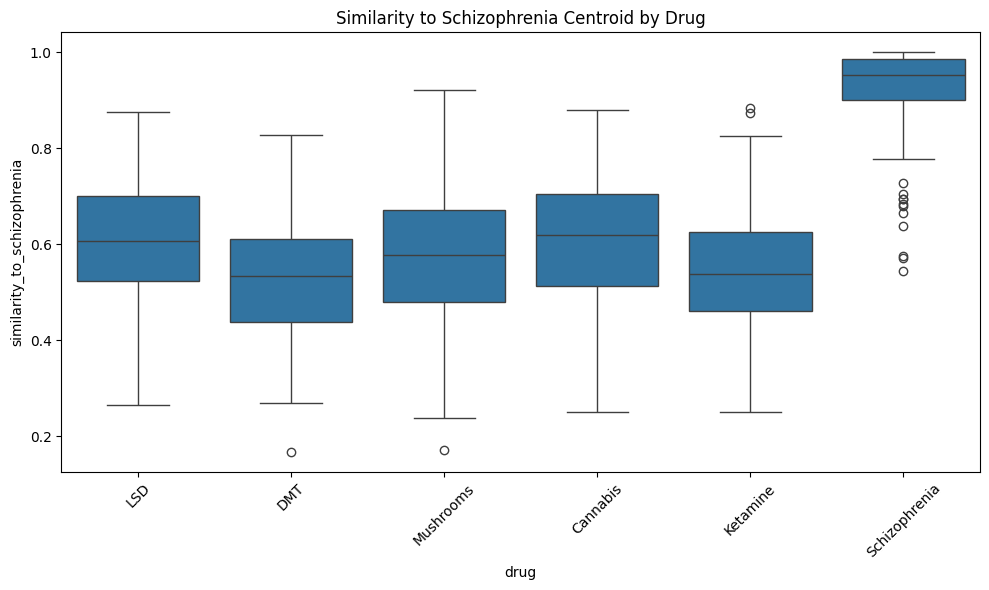

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=individual_similarity_df, x='drug', y='similarity_to_schizophrenia')
plt.xticks(rotation=45)
plt.title("Similarity to Schizophrenia Centroid by Drug")
plt.tight_layout()
plt.show()


most frequent words vs tfidf

In [99]:
def preprocess_text_for_counts(doc, stop_words):
    words = word_tokenize(doc)
    tagged_words = pos_tag(words)
    result = []
    for word, tag in tagged_words:
        clean = ''.join(filter(str.isalnum, word)).lower()
        if clean and len(clean) > 2 and not any(char.isdigit() for char in clean) and clean not in stop_words:
            pos = get_wordnet_pos(tag)
            result.append(LemmaTokenizerPOS().wnl.lemmatize(clean, pos=pos)) # Reuse the lemmatizer logic
    return result

# Create a list of processed texts for term frequency calculation
processed_texts = []
for text in concat_individual:
    processed_texts.append(preprocess_text_for_counts(text, stop_words))

# Flatten the list of lists to count all words
all_words_flat = [word for sublist in processed_texts for word in sublist]

# Count word frequencies
from collections import Counter
word_counts = Counter(all_words_flat)

# Get the most frequent words
num_most_frequent = 10
most_frequent_words = word_counts.most_common(num_most_frequent)

print(f"\nTop {num_most_frequent} Most Frequent Words (after preprocessing and stop word removal):")
for word, count in most_frequent_words:
    print(f"{word}: {count}")

print("\nTop TF-IDF words (calculated previously for each drug):")
# Display the previously calculated top TF-IDF words per drug for comparison
# (Assuming 'top_words_df' from the previous code is available)
num_top_tfidf = 10
for label in top_words_df.index:
    print(f"\nTop {num_top_tfidf} words for {label}:")
    print(top_words_df.loc[label].sort_values(ascending=False).head(num_top_tfidf))

# --- Comparison Visualization (Optional) ---
# You can visualize the overlap or difference between the two lists if desired.
# For example, find common words in the top lists.

top_frequent_word_list = [word for word, count in most_frequent_words]

# Get the list of top TF-IDF words across all drugs for comparison
top_tfidf_word_list_all = []
num_top_tfidf_overlap = 10 # Adjust as needed for overlap comparison
for label in top_words_df.index:
    top_tfidf_word_list_all.extend(top_words_df.loc[label].sort_values(ascending=False).head(num_top_tfidf_overlap).index.tolist())

top_tfidf_word_list_all = list(set(top_tfidf_word_list_all))

common_words = list(set(top_frequent_word_list) & set(top_tfidf_word_list_all))

print(f"\nWords present in both top {num_most_frequent} most frequent and top {num_top_tfidf_overlap} TF-IDF words across all drugs:")
if common_words:
    print(common_words)
else:
    print("No common words found in the top lists.")

# You could also create bar plots comparing the scores/counts of specific words
# in both ranking methods, or create a side-by-side visual comparison of the top lists.



Top 10 Most Frequent Words (after preprocessing and stop word removal):
go: 1841
get: 1400
say: 1255
start: 1255
take: 1223
around: 1221
make: 1205
thing: 1109
look: 999
really: 984

Top TF-IDF words (calculated previously for each drug):

Top 10 words for Cannabis:
really    3.936551
make      3.925368
say       3.710084
around    3.383028
thing     3.261848
tell      3.257788
hour      3.210885
never     3.062113
begin     3.051082
find      3.049139
Name: Cannabis, dtype: float64

Top 10 words for DMT:
begin         4.609779
say           3.910268
thing         3.744672
everything    3.614466
close         3.277088
seem          3.195721
minute        3.189251
make          3.184703
want          3.117527
much          3.082524
Name: DMT, dtype: float64

Top 10 words for Ketamine:
remember      4.055040
minute        3.877084
seem          3.736056
around        3.639693
really        3.611826
make          3.427738
mind          3.269925
much          3.263226
thing         3.2547